--------------------------------


In [1]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:100% !important; }</style>"))

**Papermill variables**

In [2]:
#if not provided by papermill

if 'input_path' not in globals():
    input_path = "data/outputs/structured_bner_selection1.bin"

if 'selected_page' not in globals():
    selected_page = 208
    
if 'sentence_in_focus' not in globals():
    sentence_in_focus = 2

In [3]:
import os

#note that when ran with renku run from repo root, we're in a different work directory
current_dir = os.getcwd()

if str(current_dir).split("/")[-1] == "notebooks":
    input1_file = "../" + input_path
else:
    input1_file = input_path

**Welcome message**

In [4]:
import pyfiglet
from datetime import datetime


In [5]:
#see https://strftime.org/
when = datetime.now().strftime("Date: %B %d, %Y  Time: %H:%M:%S")
    
logo = pyfiglet.figlet_format("' Renku & Papermill '", font = "slant" )
    
#user-friendly welcome
aux_n = 100
blank_line = str("***").ljust(aux_n - 3) + "***"

print("*" * aux_n)
print(logo)
print(blank_line)
print(str("***  " + when).ljust(aux_n - 3) + "***")
print(blank_line)
print(str("***  WILL RUN NOTEBOOK WITH:").ljust(aux_n - 3) + "***")
print(blank_line)
print(str("*** input_path:    " + input1_file).ljust(aux_n - 3) + "***")
print(blank_line)
print(str("*** selected_page: " +str(selected_page)).ljust(aux_n - 3) + "***")
print(blank_line)
print(str("*** sentence in focus: " +str(sentence_in_focus)).ljust(aux_n - 3) + "***")
print(blank_line)
print("*" * aux_n)

****************************************************************************************************
  _    ____             __            ___        ____                                  _ ____   _ 
 ( )  / __ \___  ____  / /____  __   ( _ )      / __ \____ _____  ___  _________ ___  (_) / /  ( )
 |/  / /_/ / _ \/ __ \/ //_/ / / /  / __ \/|   / /_/ / __ `/ __ \/ _ \/ ___/ __ `__ \/ / / /   |/ 
    / _, _/  __/ / / / ,< / /_/ /  / /_/  <   / ____/ /_/ / /_/ /  __/ /  / / / / / / / / /       
   /_/ |_|\___/_/ /_/_/|_|\__,_/   \____/\/  /_/    \__,_/ .___/\___/_/  /_/ /_/ /_/_/_/_/        
                                                        /_/                                       

***                                                                                              ***
***  Date: July 17, 2021  Time: 11:39:49                                                         ***
***                                                                                              ***
*

----------------

In [6]:
import spacy
from spacy.tokens import Doc, Token, Span, SpanGroup, DocBin
from spacy import displacy

from spacy import displacy
import deplacy
import visualise_spacy_tree

import pandas as pd
import re

import pprint

In [7]:
pd.options.display.max_colwidth = 0 
pd.options.display.max_columns = None
pd.set_option('display.width', 1000)
pp = pprint.PrettyPrinter(width=150, compact=True)

In [8]:
#register token-level and span-level extensions in Spacy
try:
    #to deserialize docbin we need to set these again
    Token.set_extension("bner", default = []) 
    Token.set_extension("IS_BODY_ORGAN", default = 0)
    Token.set_extension("IS_MEDICATION", default = 0)
    Token.set_extension("IS_DISEASE", default = 0)
    
    Span.set_extension("IS_MEDICATION", default = 0)
    Span.set_extension("MEDICATION_DETAILS", default = {})
    
    Doc.set_extension("BOOK_PAGE", default = -1)
    
    #were assigned by medspacy context 
    Span.set_extension("is_family_history", default=0)
    Span.set_extension("is_history", default=0)
    Span.set_extension("never_family_history", default=0)
    Span.set_extension("never_history", default=0)
    
    #was set based on dep matcher, on medication ents that have relations to the diseases they are taken for
    Span.set_extension("PURPOSE", default="")
    
    #for visualization
    Token.set_extension('plot', default={})     

except:
    pass

In [9]:
nlp = spacy.load("en_core_web_lg", disable = ["ner"])

print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer']


### Load Spacy DocBin

In [10]:
doc_bin = DocBin().from_disk(input1_file)

list_docs = list(doc_bin.get_docs(nlp.vocab))

**Select a doc for illustration**

In [11]:
doc = [doc for doc in list_docs if doc._.BOOK_PAGE == selected_page][0]

list_sentences = list(doc.sents)

df_sentences = pd.DataFrame([el.text for el in list_sentences], columns = ["sentence"])
df_sentences

,sentence
0,A 50-year-old male patient comes into the pharmacy to pick up his medications.
1,"The pharmacy technician approaches you, the intern, for a new counsel on citalopram 40 mg daily for depression."
2,"Upon reviewing his medication list, you notice that he is on omeprazole 20 mg daily for his gastroesophagel reflux disease (GERD)."
3,What drug-drug interaction and self-monitoring side effects would you counsel the patient on between these two medications?


-----------------------

### Visualize a dependency tree for one of the documents in the DocBin

In [12]:
 def display_tree(doc, nth_sentence = 0):
                
    #customize plot to highlight numbers, verbs and proper names
    sentence = list(doc.sents)[nth_sentence]
    print("SENTENCE:\n", sentence)
    print("-----------------------------------------------------------------------")
    for token in sentence:
        node_label = '{0}  [{1}] \n {2} / {3} \n {4}'.format(token.text, token.i, 
                                                             token.pos_, token.dep_,
                                                             token.ent_type_)
        token._.plot['label'] = node_label

        if token.ent_iob_ != "O":
            token._.plot["color"] = "red"
        else:
            if token.pos_ in ["PUNCT", "DET", "ADP", "NOUN"]:
                token._.plot["color"] = "lightgray" 
            elif token.pos_ in ["VERB", "AUX"]:
                token._.plot["color"] = "blue"
            else:
                token._.plot["color"] = "black" 

    png_tree = visualise_spacy_tree.create_png(sentence)
    display(Image(png_tree))

SENTENCE:
 A 50-year-old male patient comes into the pharmacy to pick up his medications.
-----------------------------------------------------------------------


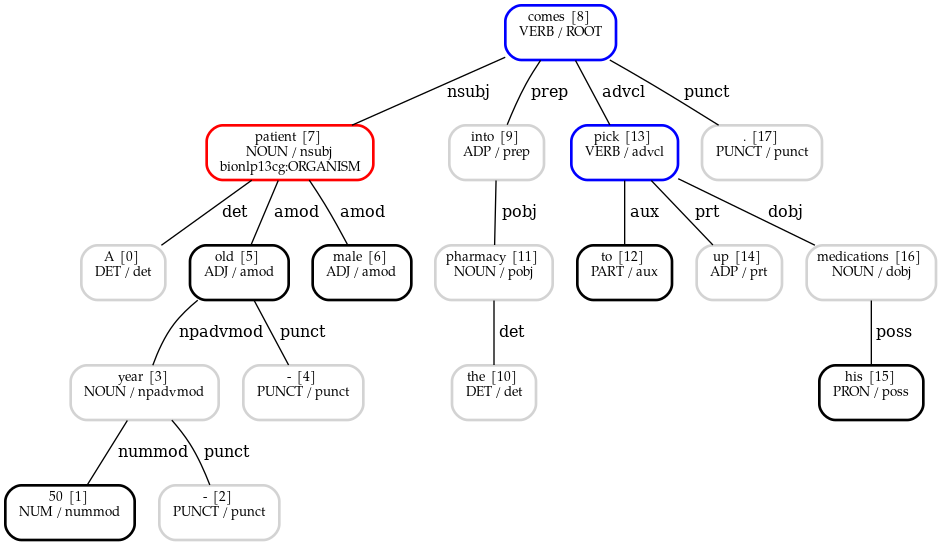

In [13]:
display_tree(doc, nth_sentence = 0)

SENTENCE:
 Upon reviewing his  medication list, you notice that he is on omeprazole 20 mg daily for his gastroesophagel reflux disease (GERD).
-----------------------------------------------------------------------


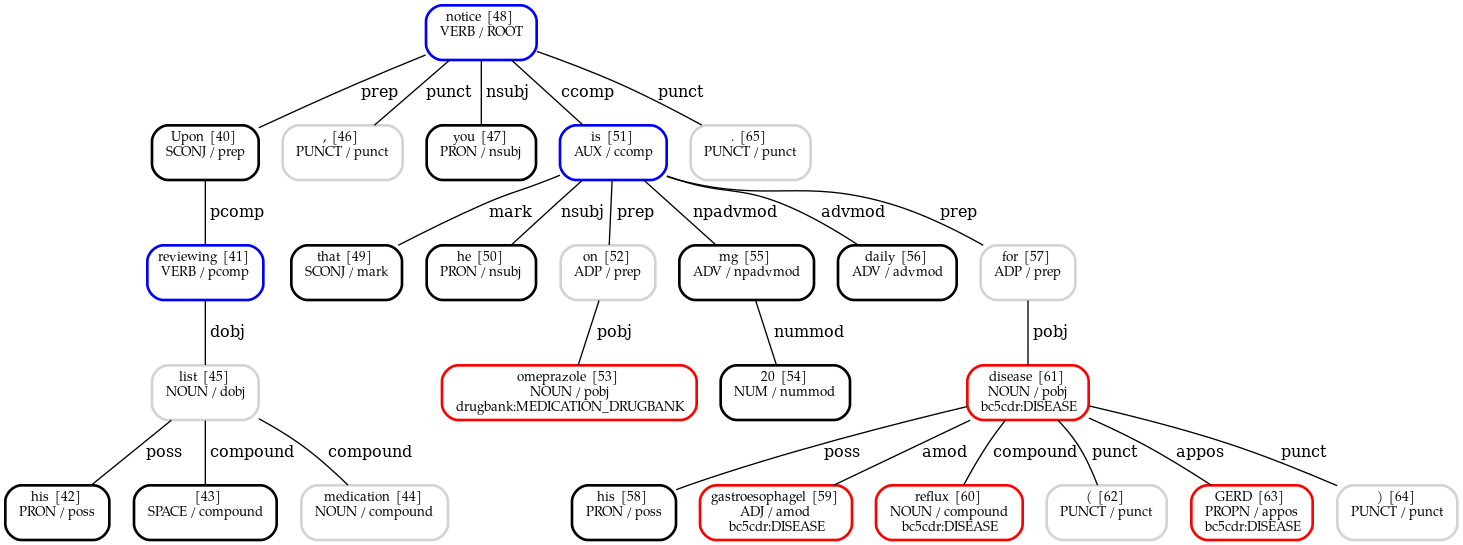

In [14]:
display_tree(doc, nth_sentence = sentence_in_focus)

**Alternative view:**

In [15]:
deplacy.render(list_sentences[sentence_in_focus],
               BoxDrawingWidth=1,EnableCR=False,WordRight=False,CatenaAnalysis=True)

Upon            SCONJ ═════════╗<══════════════╗     prep
reviewing       VERB  ═══════╗<╝               ║     pcomp
his             PRON  <════╗ ║                 ║     poss
                SPACE <══╗ ║ ║                 ║     compound
medication      NOUN  <╗ ║ ║ ║                 ║     compound
list            NOUN  ═╝═╝═╝<╝                 ║     dobj
,               PUNCT <════════════════════════║═╗   punct
you             PRON  <══════════════════════╗ ║ ║   nsubj
notice          VERB  ═════════════════════╗═╝═╝═╝═╗ ROOT
that            SCONJ <══════════════════╗ ║       ║ mark
he              PRON  <════════════════╗ ║ ║       ║ nsubj
is              AUX   ═══╗═╗═╗═══════╗═╝═╝<╝       ║ ccomp
on              ADP   ═╗<╝ ║ ║       ║             ║ prep
omeprazole      NOUN  <╝   ║ ║       ║             ║ pobj
20              NUM   <╗   ║ ║       ║             ║ nummod
mg              ADV   ═╝<══╝ ║       ║             ║ npadvmod
daily           ADV   <══════╝       ║             ║ 

---------------------

### Token level data

In [16]:
def inspect_tokens(doc, nth_sentence = 0):
    """prepare a dataframe with info about the tokens of the nth sentence of doc"""
    
    sentence = list(doc.sents)[nth_sentence]
    list_info_tokens = [{"token" : tok.text,
                         "parent_ent" : tok.ent_type_,
                         "IS_BODY_ORGAN" : tok._.IS_BODY_ORGAN ,
                         "IS_DISEASE" : tok._.IS_DISEASE,
                         "IS_MEDICATION" : tok._.IS_MEDICATION,
                         "list_ents" : tok._.bner,
                         "pos" : tok.pos_,
                         "dep" : tok.dep_,
                         "morph" :tok.morph,
                         "head" : tok.head
                        
                        } 
                        for tok in sentence]
    df_tokens = pd.DataFrame(list_info_tokens)
    
    return df_tokens

In [17]:
inspect_tokens(doc, nth_sentence = sentence_in_focus)

,token,parent_ent,IS_BODY_ORGAN,IS_DISEASE,IS_MEDICATION,list_ents,pos,dep,morph,head
0,Upon,,0,0,0,(),SCONJ,prep,(),notice
1,reviewing,,0,0,0,(),VERB,pcomp,"(Aspect=Prog, Tense=Pres, VerbForm=Part)",Upon
2,his,,0,0,0,(),PRON,poss,"(Gender=Masc, Number=Sing, Person=3, Poss=Yes, PronType=Prs)",list
3,,,0,0,0,(),SPACE,compound,(NumType=Card),list
4,medication,,0,0,0,(),NOUN,compound,(Number=Sing),list
5,list,,0,0,0,(),NOUN,dobj,(Number=Sing),reviewing
6,",",,0,0,0,(),PUNCT,punct,(PunctType=Comm),notice
7,you,,0,0,0,(),PRON,nsubj,"(Case=Nom, Person=2, PronType=Prs)",notice
8,notice,,0,0,0,(),VERB,ROOT,"(Tense=Pres, VerbForm=Fin)",notice
9,that,,0,0,0,(),SCONJ,mark,(),is


**Notes:** observe how a token (such as "omeprazole") has one main entity that it belongs to (of type "drugbank:MEDICATION_DRUGBANK") but has been recognized as biomedical entity by multiple models, so those annotations are stored in its custom extension tok._.bner

----------------

### Entities-level data

In [18]:
def inspect_entities(doc, nth_sentence = 0 ):
    """prepare a dataframe with info about the entities found in the nth sentence of doc"""
    sentence = list(doc.sents)[nth_sentence]
    
    list_info_entities = [{"entity" : ent.text,
                           "label" : ent.label_,
                           "IS_MEDICATION": ent._.IS_MEDICATION,
                           "PURPOSE" : ent._.PURPOSE,
                           "MEDICATION_DETAILS" : ent._.MEDICATION_DETAILS,
                           "family_past" : ent._.is_family_history,
                           "history" : ent._.is_history,
                           "not_family_past" : ent._.never_family_history,
                           "not_history" : ent._.never_history,                           
                           "start_char" : ent.start_char,
                           "end_char" : ent.end_char,
                           "start_tok" : ent.start,
                           "end_tok" : ent.end ,
                        
                        } 
                        for ent in sentence.ents]
    df_entities = pd.DataFrame(list_info_entities)
    
    return df_entities
        

In [19]:
inspect_entities(doc, nth_sentence = sentence_in_focus)

,entity,label,IS_MEDICATION,PURPOSE,MEDICATION_DETAILS,family_past,history,not_family_past,not_history,start_char,end_char,start_tok,end_tok
0,omeprazole,drugbank:MEDICATION_DRUGBANK,1,,"{'drugbank_id': 'DB00338', 'rxnorm_link': ('C0028978', 'Omeprazole', (), ('T109', 'T121'), 'A 4-methoxy-3,5-dimethylpyridyl, 5-methoxybenzimidazole derivative of timoprazole that is used in the therapy of STOMACH ULCERS and ZOLLINGER-ELLISON SYNDROME. The drug inhibits an H(+)-K(+)-EXCHANGING ATPASE which is found in GASTRIC PARIETAL CELLS.')}",0,0,0,0,254,264,53,54
1,gastroesophagel reflux disease,bc5cdr:DISEASE,0,,{},0,0,0,0,285,315,59,62
2,GERD,bc5cdr:DISEASE,0,,{},0,0,0,0,317,321,63,64


---------------------------------

In [20]:
def visualize_entities(doc, nth_sentence = 0):
    sentence = list(doc.sents)[nth_sentence]
    
    colors = {"drugbank:MEDICATION_DRUGBANK" : "#fce9a2", "bc5cdr:DISEASE":"#facdee"}
    html_ents = displacy.render(sentence, style='ent', 
                                options={"colors":colors}, 
                                page=True, jupyter=False, minify=True)
    return html_ents


In [21]:
html_ents = visualize_entities(doc, nth_sentence = sentence_in_focus)

display(HTML(html_ents))

**Inspecting the HTML produced, for better understanding we highlight HTML tags in the text**

In [22]:
html_ents

'<!DOCTYPE html><html lang="en"><head><title>displaCy</title></head><body style="font-size: 16px; font-family: -apple-system, BlinkMacSystemFont, \'Segoe UI\', Helvetica, Arial, sans-serif, \'Apple Color Emoji\', \'Segoe UI Emoji\', \'Segoe UI Symbol\'; padding: 4rem 2rem; direction: ltr"><figure style="margin-bottom: 6rem"><div class="entities" style="line-height: 2.5; direction: ltr">Upon reviewing his  medication list, you notice that he is on <mark class="entity" style="background: #fce9a2; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">omeprazole<span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">drugbank:MEDICATION_DRUGBANK</span></mark> 20 mg daily for his <mark class="entity" style="background: #facdee; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">gastroesophagel reflux disease<span style="font-size: 0.8em; font-weight: bold; li

In [23]:
#utility for custom printing - from https://stackoverflow.com/questions/8924173/how-do-i-print-bold-text-in-python/8930747

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [24]:
#we bold and color some of the html tags for better analysis of this produced html 

ss = """<span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">"""

html_ents_postproc = ( html_ents
                      .replace("</mark>", color.BOLD + color.BLUE + "</mark>" + color.END)
                      .replace(ss, color.BOLD + color.PURPLE + ss + color.END)
                      .replace("</span>", color.BOLD + color.PURPLE + "</span>" + color.END)
                     )

#for styling the <mark> tags we need a REGEX, the matching group (in paranthesis) is later found as \g1
# test the regex at https://regexr.com/

rgx = re.compile(r'(<mark class="entity" [^>]*>)')
html_ents_postproc = rgx.sub(color.BOLD + color.BLUE + r'\1' + color.END, html_ents_postproc)


In [25]:
html_ents_postproc2 = html_ents_postproc.replace(">", ">#").replace("<","#<")
print("\n".join(html_ents_postproc2.split("#")))


<!DOCTYPE html>

<html lang="en">

<head>

<title>
displaCy
</title>

</head>

<body style="font-size: 16px; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol'; padding: 4rem 2rem; direction: ltr">

<figure style="margin-bottom: 6rem">

<div class="entities" style="line-height: 2.5; direction: ltr">
Upon reviewing his  medication list, you notice that he is on 
<mark class="entity" style="background: 
fce9a2; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
omeprazole
<span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">
drugbank:MEDICATION_DRUGBANK
</span>

</mark>
 20 mg daily for his 
<mark class="entity" style="background: 
facdee; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
gastroesophagel reflux disease
<span style="font-size: 0.8em; f